In [ ]:
import torch
print("PyTorch version:", torch.__version__)
print("Cuda available: ", torch.cuda.is_available())
!nvcc --version

# SETUP ENVIRONMENT (Run just once!)

Remember that you need Python v3.8.

In [ ]:
!git clone https://github.com/clovaai/donut.git
!cd donut && pip install .
!pip install -r requirements.txt

### Check if critical packages (torch, timm, pytorch-lightning) have the expected versions.

In [ ]:
!pip list

# Checking base model

Checking if the base model works as expected using a sample located in the `misc/` folder.

In [ ]:
from donut import DonutModel
from PIL import Image
import torch

In [ ]:
model = DonutModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2", ignore_mismatched_sizes=True)

In [ ]:
device = torch.device("cuda")
model.to(device)
print("model ready!")

In [ ]:
image = Image.open("./donut/misc/sample_image_cord_test_receipt_00004.png")

In [ ]:
image

In [ ]:
model.half()
model.to(device)
model.eval()

output = model.inference(image=image, prompt="<s_cord-v2>")
output

In [ ]:
import json
print(json.dumps(output, indent=2))

In [ ]:
!pip list

# FINE-TUNING

Please run the shell script located at the same directory as this notebook (`train.sh`).

Source that was really useful to build the fine-tuning pipeline: [towards data science](https://towardsdatascience.com/ocr-free-document-understanding-with-donut-1acfbdf099be/)

### IMPORTANT

Do not forget to update `donut/config/train_custom.yaml` (or any existing or new config file):

- Dataset path
- Results path
- Hyperparameters (n. of epochs, learning rate, batch size, etc.)
- special tokens list

In [ ]:
# Clear cache if needed
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=memory.used --format=csv,noheader

In [ ]:
!cd donut && python train.py --config config/train_custom.yaml

# TESTING INFERENCE

The `test()` function defined below will allow to check the model's accuracy over the test subset. It will output the prediction and ground-truth for each sample in this set, together with the final average accuracy and F1 scores.

In [1]:
from tqdm.notebook import tqdm
from donut import DonutModel, JSONParseEvaluator, load_json, save_json
import numpy as np
import os
from datetime import datetime
from datasets import load_dataset
import json
import torch

def test(model_path, data_path, task_name, save_path = None, split = "test"):
    model = DonutModel.from_pretrained(model_path)

    model.half()
    model.to("cuda")
    model.eval()

    current_timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
    if save_path:
        save_path = os.path.join(save_path, current_timestamp)
        os.makedirs(save_path)

    predictions = []
    ground_truths = []
    accs = []

    evaluator = JSONParseEvaluator()
    dataset = load_dataset(data_path, split=split)

    for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
        ground_truth = json.loads(sample["ground_truth"])

        output = model.inference(image=sample["image"], prompt=f"<s_{task_name}>")["predictions"][0]
        gt = ground_truth["gt_parse"]
        score = evaluator.cal_acc(output, gt)

        accs.append(score)
        predictions.append(output)
        ground_truths.append(gt)

        print("---------------------------")
        print(f"Prediction:\n{output}\n")
        print(f"Ground-truth:\n{gt}\n")
        print("---------------------------")

    scores = {
        "ted_accuracies": accs,
        "ted_accuracy": np.mean(accs),
        "f1_accuracy": evaluator.cal_f1(predictions, ground_truths),
    }
    print(f"Total number of samples: {len(accs)}")
    print(f"Tree Edit Distance (TED) based accuracy score: {scores['ted_accuracy']}")
    print(f"F1 accuracy score: {scores['f1_accuracy']}")

    if save_path:
        scores["predictions"] = predictions
        scores["ground_truths"] = ground_truths
        save_json(os.path.join(save_path, 'scores.json'), scores)

    return predictions    

### IMPORTANT

Point this variables to your prefered results folder. Note that you will find your results by going to `donut/`, then opening the folder you selected to be the results path, then your task name (named after your config file), and finally the timestamp of your prefered training. If it is the last one that you run, you can find that timestamp in the steps of the training.

**It is very important** to update the task name to fit your case. The task name must have the same name as your dataset.

In [2]:
exp_name = "20250819_080024"
trained_model_path = f"./donut/result_extent/train_custom_v2/{exp_name}"
# workspace/donut/result_extent/train_custom_v2/20250819_080024/events.out.tfevents.1755590462.791c82fca5b1
test_results_path = f"{trained_model_path}/test_results"

dataset_path = "./donut-hybrid"

task = "donut-hybrid"

In [3]:
predictions = test(
    trained_model_path,
    dataset_path,
    task,
    test_results_path
)

/workspace/venvs/py38/lib/python3.8/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_lo

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

---------------------------
Prediction:
{'id': 'INV4262225', 'date': '30-Sep-2023', 'cur': '$', 'vendor': '1WorldSync, Inc.', 'po': '5400945798', 'corp': 'None', 'pub': '1WorldSync, Inc.', 'ltype': 'Subscription', 'ctype': 'None', 'atype': 'None', 'products': {'name': 'Item Management (IM)', 'sku': 'None', 'met': 'Custom Compare Value', 'metgr': 'None', 'qty': '0.5', 'unpr': '$326,000.00', 'totpr': '$163,000.00', 'drom': '01-Oct-2022.', 'dto': '30-Sep-2024', 'issub': 'Yes'}}

Ground-truth:
{'id': 'INV4262225', 'date': '30-Sep-2023', 'cur': '$', 'vendor': '1WorldSync, Inc.', 'po': '5400945798', 'corp': None, 'pub': '1WorldSync, Inc.', 'ltype': 'Subscription', 'ctype': None, 'atype': None, 'products': {'name': ['Item Management (IM)'], 'sku': [None], 'met': ['Custom Compare Value'], 'metgr': [None], 'qty': ['0.5'], 'unpr': ['$326,000.00'], 'totpr': ['$163,000.00'], 'drom': ['01-Oct-2022.'], 'dto': ['30-Sep-2024'], 'issub': ['Yes']}}

---------------------------
--------------------------

# READ TENSORFLOW RESULTS LOG

Tensorflow logs are saved in `tfevents` files. Find them in your results folder with a name like `events.out.tfevents.<>.<>`.

[Source](https://medium.com/@kaige.yang0110/how-to-read-tensorboard-log-files-and-plot-your-own-figures-a6622018a999)

In [4]:
import os

results_path = "donut/result_extent/train_custom_v2"
exp_name = "20250819_080024"
tf_file_name = "events.out.tfevents.1755590462.791c82fca5b1"

log_path = os.path.join(results_path, exp_name, tf_file_name)
os.path.exists(log_path)

True

In [5]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt

In [6]:
reader = SummaryReader(log_path)
df = reader.scalars

In [ ]:
print(df.head(10))

In [ ]:
tags = df["tag"].unique()
print('Tags:', tags)

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(tf_df: pd.DataFrame, save: bool = False):
    tf_tags = tf_df["tag"].unique()
    
    for i, tag in enumerate(tf_tags):
        print('--- tag index', i, tag)
        tag_df = tf_df[tf_df["tag"] == tag]
    
        plt.figure(figsize=(6, 4))
        plt.plot(tag_df['step'].values, tag_df['value'].values)
        plt.title(tag, fontsize=12)
        plt.xlabel('step', fontsize=12)
        plt.ylabel('value', fontsize=12)
        plt.tight_layout()

        if save:
            plots_folder = os.path.join(results_path, exp_name, 'results_plots')
            if not os.path.exists(plots_folder):
                os.makedirs(plots_folder)
            plt.savefig(os.path.join(plots_folder, f"{tag.split('/')[-1]}.png"), dpi=100)
            plt.close()
        else:
            plt.show()

--- tag index 0 epoch


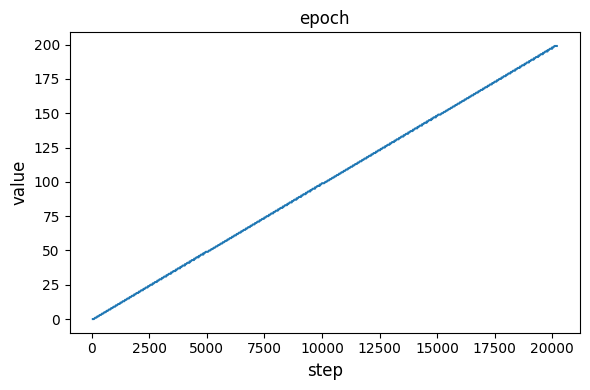

--- tag index 1 learning_rate


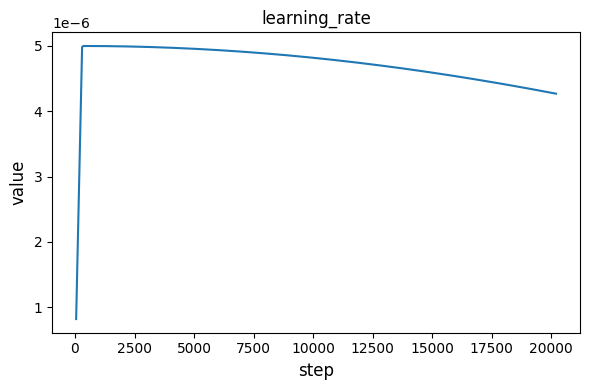

--- tag index 2 train_loss


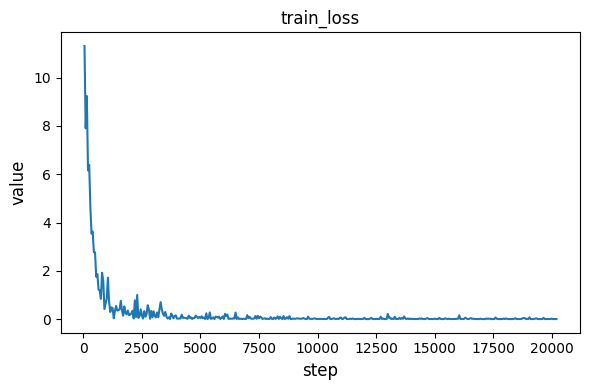

--- tag index 3 val_metric


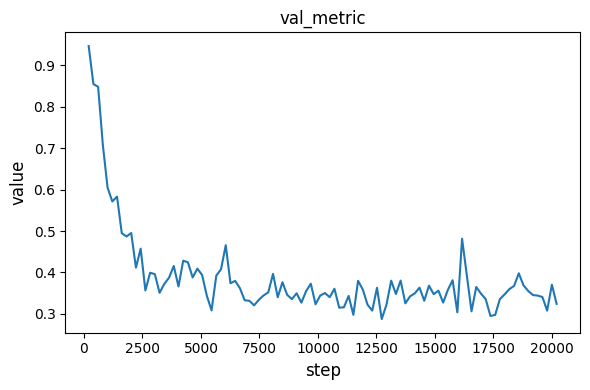

--- tag index 4 val_metric_0th_dataset


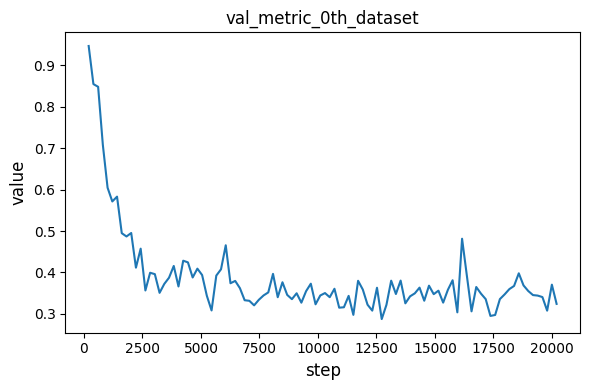

In [8]:
%matplotlib inline

plot_results(df, save=False)

# Tests with real samples

In [13]:
# Real samples directory
test_real_path = 'subset_real_samples'
os.path.exists(test_real_path)

True

In [14]:
exp_name = "20250814_063702"
trained_model_path = f"./donut/result_extent/train_custom/{exp_name}"

test_results_path = f"{trained_model_path}/test_results"

task = "donut-clem"

In [ ]:
predictions = test(
    trained_model_path,
    test_real_path,
    task,
    test_results_path
)

In [21]:
split='test'
dataset = load_dataset(test_real_path, split=split)
dataset

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 7
})